# Flanker

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [16]:
#!pip install git+https://github.com/lnccbrown/HSSM.git

In [17]:
# necessary imports
from matplotlib import pyplot as plt
import numpy as np
import hssm
import hssm.plotting
hssm.set_floatX("float32")
import pandas as pd
import arviz as az
from scipy.stats import norm
import random

import warnings
warnings.filterwarnings("ignore")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


The following code defines two classes, Spotlight_DDM and Spotlight_DDM_with_variable_z, representing variants of the drift diffusion model (DDM), and a plotting function to visualize the simulation results.

**Spotlight_DDM:**

*   This class represents a basic implementation of the drift diffusion model.
*   It simulates the accumulation of evidence over time without any adjustment to the starting point (z) during the simulation.
*   The starting point remains constant throughout the simulation, as specified during initialization.
*   The decision-making process relies solely on the fixed starting point, drift rate, and noise.

**Spotlight_DDM_with_variable_z:**

*   This class extends the basic drift diffusion model by introducing a mechanism to adjust the starting point (z) during the simulation.
*   It allows the starting point to dynamically change based on the decision outcomes during the simulation.
*   When a decision is made (reaching one of the decision thresholds), the starting point is adjusted in the direction of the decision to bias future decisions.
*   This adjustment mechanism can be useful for modeling cognitive processes where decision biases or adjustments occur over time, such as learning or adaptation to changing environments.


The main difference between the two models lies in the treatment of the starting point (z): the basic model keeps it fixed, while the extended model allows it to be adjusted dynamically during simulation based on decision outcomes.

*The targeted hypothesis is that after the multiple trials where the flanker pointed in a certain direction, the participant is biased towards or against this flanker direction and the the offset (the starting point z) shifts towards one of the decision boundaries.*

In [18]:
# Class for simulating the DDM with fixed starting point
class Spotlight_DDM():
    def __init__(self, name):
        """
        Initialize the Spotlight_DDM object.

        Args:
        - name (str): A name to distinguish different instances of the model.
        """
        self.name = name # to distinguish models properly


    def run(self, v,
                threshold,
                starting_point,
                noise_std,
                non_decision_time,
                dt,
                max_time, **kwargs):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - p_total: perceptual input for target and distractor flankers of shape [target, distractors] (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - starting_point: initial condition of the evidence
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = starting_point
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise
            evidence += v * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                return time, evidence_over_time, 1  # Decision made for the upper threshold (right)
            elif evidence <= 0:
                return time, evidence_over_time, -1  # Decision made for the lower threshold (left)

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0


# Class for simulating the Drift Diffusion Model (DDM) with variable starting point (z)
class Spotlight_DDM_with_variable_z():
    def __init__(self, name, starting_point: float):
        """
        Initialize the Spotlight_DDM_with_variable_z object.

        Args:
        - name (str): A name to distinguish different instances of the model.
        - starting_point (float): Initial starting point for evidence accumulation.
        """
        self.name = name  # to distinguish models properly
        self.starting_point = starting_point
        self.z = starting_point

    def run(self, v, threshold, noise_std, non_decision_time, dt, max_time, increment_step: float = 0, **kwargs):
        """
        Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

        Arguments:
        - v: perceptual input for target flanker (values can be -1 (left) or 1(right))
        - sd_a: standard deviation of attention allocation distribution (spotlight width)
        - r: temporal decay of the standard deviation of attention (spotlight narrowing term)
        - threshold: evidence needed to reach a decision
        - noise_std: standard deviation of the noise term
        - non_decision_time: time not included in the evidence accumulation process
        - dt: time increment
        - max_time: maximum simulation time
        - increment_step: increment to adjust

        Returns:
        - decision_time: the time taken to reach a decision
        - evidence_over_time: the evidence accumulated over time
        - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
        """
        # Initialize evidence accumulation process
        time = non_decision_time
        evidence = self.z
        evidence_over_time = [evidence]

        # Run the simulation until a decision boundary is reached or max time is exceeded
        while time < max_time:
            # Increment the evidence by the drift and some noise
            evidence += v * dt + np.sqrt(dt) * np.random.normal(0, noise_std)
            evidence_over_time.append(evidence)
            time += dt  # Increment the time

            # Check if the evidence has reached either threshold
            if evidence >= threshold:
                # Decision made for the upper threshold
                self.adjust_starting_point(1, increment_step)
                return time, evidence_over_time, 1

            elif evidence <= 0:
                # Decision made for the lower threshold
                self.adjust_starting_point(-1, increment_step)
                return time, evidence_over_time, -1

        # If no decision has been made by max_time, return the current state
        return time, evidence_over_time, 0

    def adjust_starting_point(self, direction: int, increment: float):
        """
        Adjust the starting point (z) based on the direction of the decision and the specified increment.

        Args:
        - direction (int): Direction of the decision (-1 for left, 1 for right).
        - increment (float): Increment value to adjust the starting point.
        """
        if (self.z >= self.starting_point and direction == 1) or (self.z <= self.starting_point and direction == -1):
            self.z += increment * direction
            # print(f"Adjusted to {self.z}")
        else:
            self.z = self.starting_point
            # print("Reset to default.")



def plotting(decision_time, evidence_over_time, decision):
    """
    Plot the evidence accumulation process.

    Args:
    - decision_time (float): Time taken to reach a decision.
    - evidence_over_time (list): Evidence accumulated over time.
    - decision (int): Decision outcome (1 for right, -1 for left, 0 for no decision).
    """
    plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
    plt.axhline(y=a, color='green', linestyle='--')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Time (s)')
    plt.ylabel('Evidence')
    plt.title(f'Drift Diffusion Model (Decision: {"Right" if decision == 1 else "Left" if decision == 0 else "None"})')
    plt.show()
    return



## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


The following code snippet sets parameters for simulating the **Spotlight_DDM** and then visualizes the evidence accumulation process.

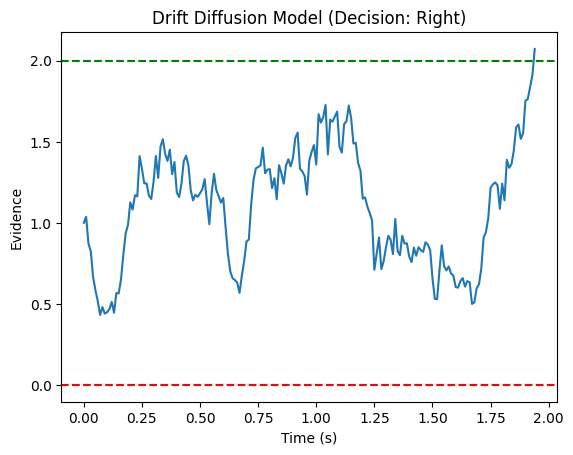

In [19]:
ddm = Spotlight_DDM("my_ddm")
p_total = 1 # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

# Run the DDM simulation
decision_time, evidence_over_time, decision = ddm.run(v = p_total,
                                                  threshold = a,
                                                  starting_point = z,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time)

# Plot the evidence accumulation process
plotting(decision_time, evidence_over_time, decision)

The following code snippet sets parameters for simulating the **Spotlight_DDM_with_variable_z** and then visualizes the evidence accumulation process.

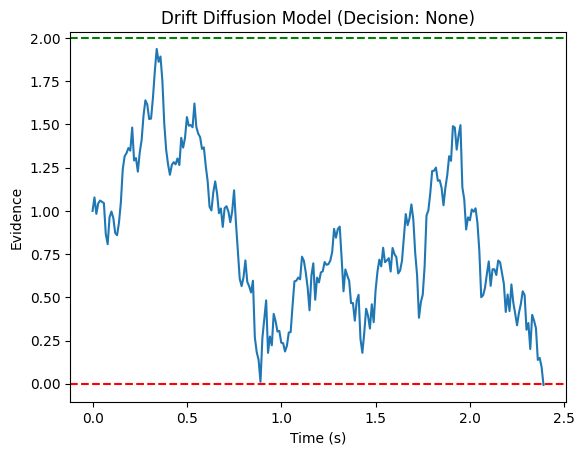

In [20]:
p_total = 1 # incongruent trial with target pointing to the right and distractors pointing left
r = 0.2           # attention narrowing parameter
sd_a = 1          # initial attention standard deviation
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
increment = 0.1   # directional increment for adjusting the z-param
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

ddm = Spotlight_DDM_with_variable_z("my_variable_ddm", starting_point = z)

# Run the DDM simulation
decision_time, evidence_over_time, decision = ddm.run(v = p_total,
                                                  threshold = a,
                                                  increment_step = increment,
                                                  noise_std = sigma,
                                                  non_decision_time = t0,
                                                  dt = dt,
                                                  max_time = max_time)

# Plot the evidence accumulation process
plotting(decision_time, evidence_over_time, decision)

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



This code snippet conducts Bayesian inference through Markov Chain Monte Carlo (MCMC) sampling for two drift diffusion models. The process involves executing Bayesian inference for both models using the NUTS (No-U-Turn Sampler) algorithm implemented in NumPyro. Configurations for the sampling process include parameters like the number of chains, draws, tune steps, and the type of data used for model comparison.

In [21]:
# using MCMC sampling
# 1) load the data
data = pd.read_csv("../data/3029.csv", delimiter = ";")
data.head()

# 2) prepare the models

varying_starting_point_model = hssm.HSSM(
    data = data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous_response",
        }
    ],
)

basic_ddm_model = hssm.HSSM(
    data = data,
)


# 3) fit both models using mcmc sampling
varying_starting_point_model_inference = varying_starting_point_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

basic_ddm_model_inference = basic_ddm_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

Compiling...
Compilation time = 0:00:02.357877
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:40.907131
Transforming variables...
Transformation time = 0:00:00.064825
Computing Log Likelihood...
Log Likelihood time = 0:00:00.586839
Compiling...
Compilation time = 0:00:02.480858
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:08.225040
Transforming variables...
Transformation time = 0:00:00.066351
Computing Log Likelihood...
Log Likelihood time = 0:00:00.571924


In this snippet the traces from each model's Bayesian inference are passed as input to the az.compare function.


In [22]:
# Compare the models based on their posterior probabilities
model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model.traces,
        "basic": basic_ddm_model.traces,
    }
)

The output of az.compare provides a comparison between the models, typically in terms of statistical metrics such as WAIC (Widely Applicable Information Criterion) or LOO (Leave-One-Out) cross-validation.

In [23]:
model_comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
basic,0,-1378.385485,0.029898,0.000000,1.000000e+00,0.016407,0.000000,False,log
varying starting point,1,-2787.317703,2333.263296,1408.932219,9.134737e-11,33.663998,33.673176,True,log


The plot_trace() function is called on the **varying_starting_point_model** object to generate trace plots that visualize the sampled values of parameters over iterations (chains) of the MCMC sampling process.

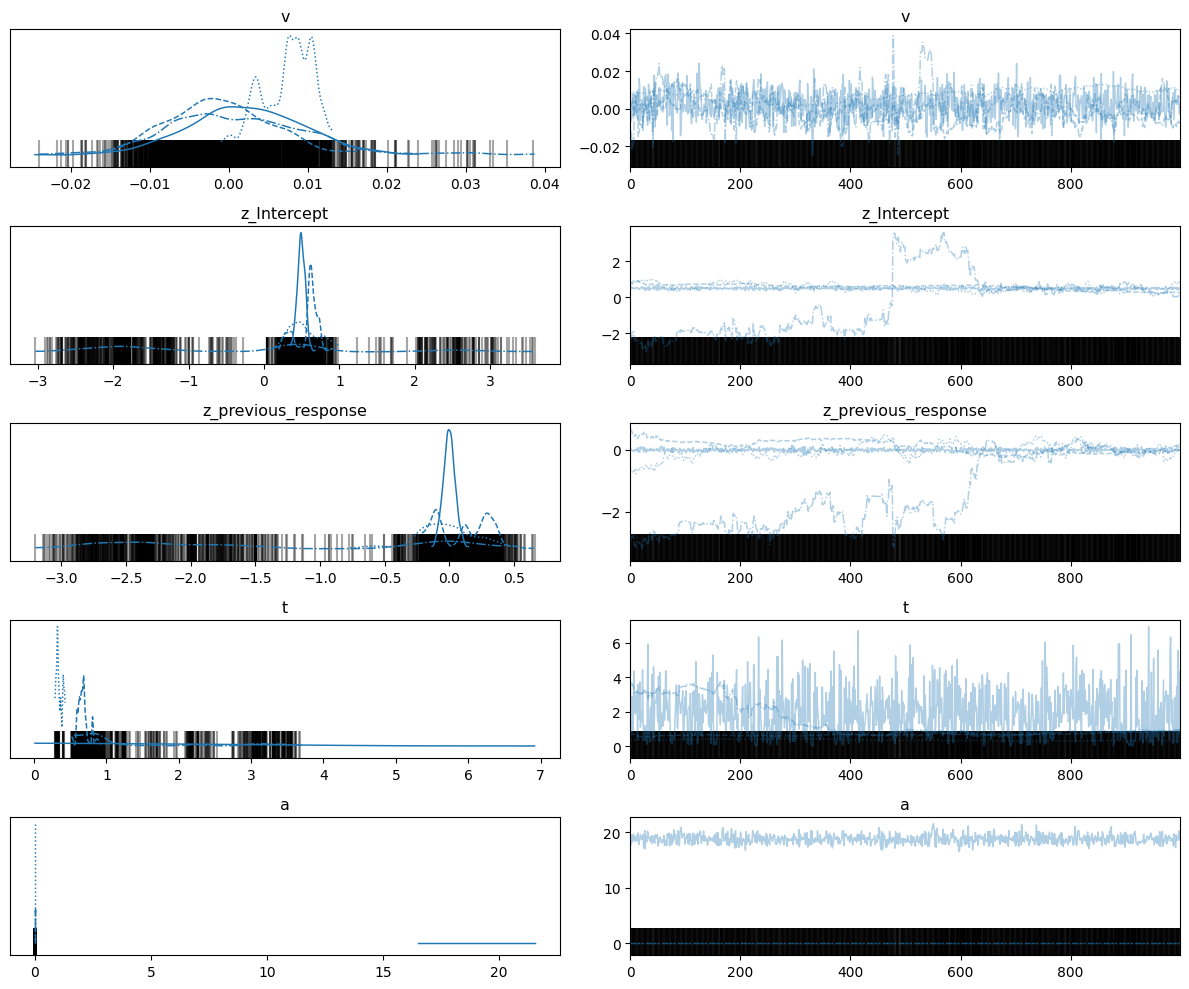

In [24]:
varying_starting_point_model.plot_trace()

The plot_trace() function is called on the **basic_ddm_model** object to generate trace plots that visualize the sampled values of parameters over iterations (chains) of the MCMC sampling process.

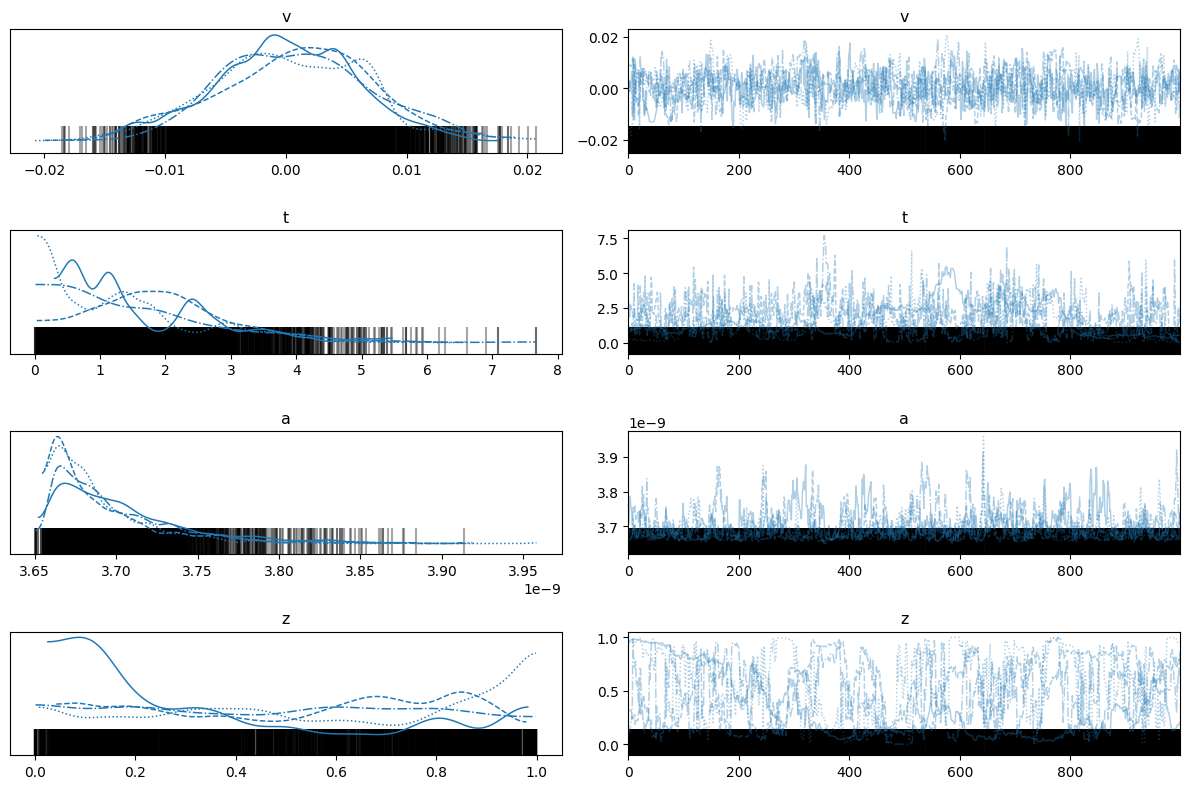

In [25]:
basic_ddm_model.plot_trace()

In the following code we do the same as before for 3029.csv - so creating the models, conducting Bayesian inference using MCMC sampling, comparing the models using ArviZ and creating trace plots for both models - just with the official Stanford data and some data manipulation to prepare it for modeling.

Compiling...
Compilation time = 0:00:02.301953
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.521737
Transforming variables...
Transformation time = 0:00:00.063432
Computing Log Likelihood...
Log Likelihood time = 0:00:01.288534
Compiling...
Compilation time = 0:00:02.597101
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.658045
Transforming variables...
Transformation time = 0:00:00.088044
Computing Log Likelihood...
Log Likelihood time = 0:00:01.377917


                        rank      elpd_loo        p_loo  elpd_diff  weight  \
basic                      0 -82622.244148  1927.614464    0.00000     1.0   
varying starting point     1 -82978.776009   180.275646  356.53186     0.0   

                              se       dse  warning scale  
basic                   6.609037  0.000000     True   log  
varying starting point  1.273564  6.652592     True   log  


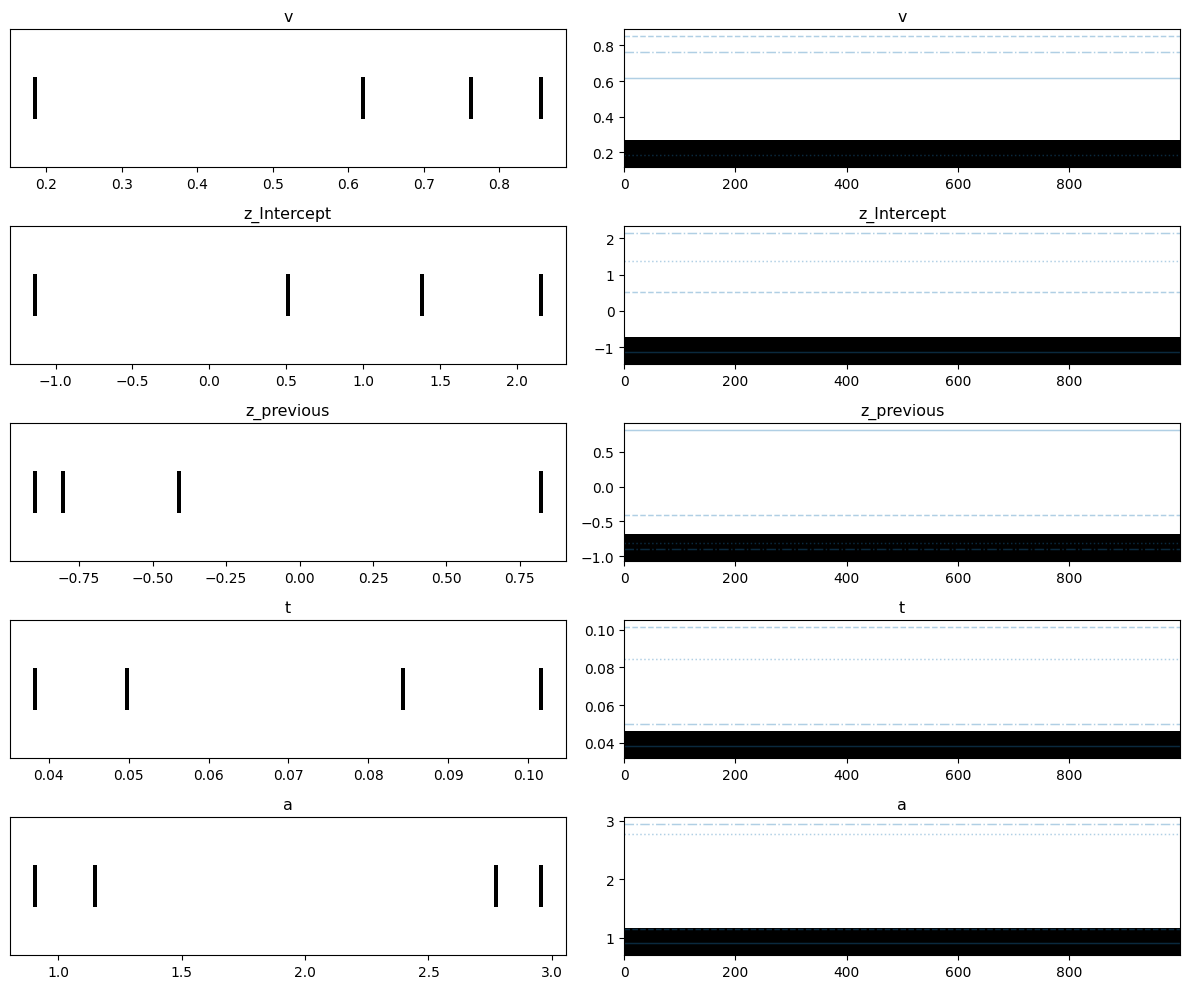

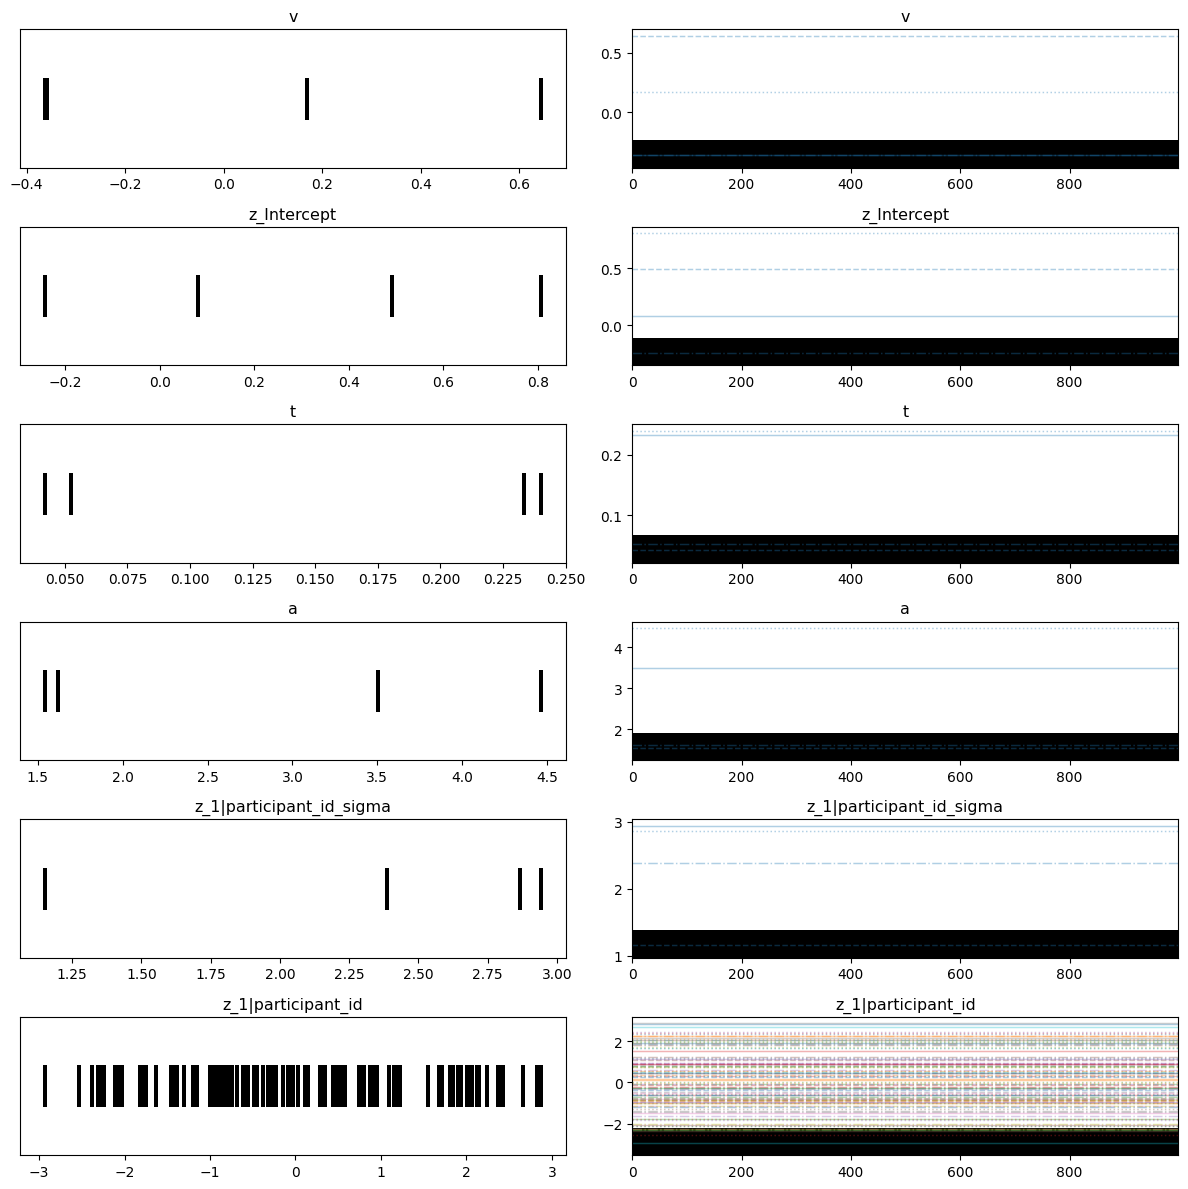

In [26]:
official_data = pd.read_csv("../data/data.csv", delimiter = ",")

# make StimVar the response column and switch values everywhere, where there is a 0 in Response
# Adjust column names and data types, drop unnecessary columns
falsies = np.where(official_data["Response"] == 0)[0]

for index in range(len(falsies)):
    official_data.at[falsies[index], "StimVar"] = 1 if official_data.at[falsies[index], "StimVar"] == 2 else 2

# Create a new column 'previous' with the shifted values of 'StimVar'
official_data['previous'] = official_data.loc[:, 'StimVar']
official_data['previous'] = official_data['StimVar'].shift(1)

# Drop unnecessary columns and rename columns for clarity
official_data = official_data.drop(['Response', 'Condition', 'Onset', 'Block'], axis = 1)
official_data = official_data.rename(columns={"SubjectID": "participant_id", "StimVar": "response", "RT": "rt"})

# Encode 'response' column values as -1 and 1
official_data["response"] = np.where(official_data["response"] == 2, 1, -1)
official_data.at[0, 'previous'] = 0
official_data['previous'] = official_data['previous'].astype('int')

# Create drift diffusion models with specified formulas
varying_starting_point_model_on_official_data = hssm.HSSM(
    data = official_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous",
        }
    ],
)

basic_model_on_official_data = hssm.HSSM(
    data = official_data,
    include=[
        {
            "name": "z",
            "formula": "z ~ (1|participant_id)",
        }
    ],
)

# 3) fit both models using mcmc sampling
varying_starting_point_model_on_official_data_inference = varying_starting_point_model_on_official_data.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

basic_model_on_official_data_inference = basic_model_on_official_data.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

# Compare models using ArviZ
model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model_on_official_data.traces,
        "basic": basic_model_on_official_data.traces,
    }
)
print(model_comparison)

# Generate trace plots for both models
varying_starting_point_model_on_official_data.plot_trace()
basic_model_on_official_data.plot_trace()

In the following code the data for the drift diffusion model is simulated using the simulate_data function from the hssm module, with specified parameters and a sample size of 500.

In [27]:
# Define parameters for the DDM simulation
v = 0.5             # drift rate
a = 2.0             # threshold
z = 1.0             # starting point (between 0 and threshold a)
t0 = 0.2            # non-decision time

true_values = [v, a, z, t0]

# Simulate data for the DDM using specified parameters
hssm_dataset = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=500,
)

hssm_dataset

,rt,response
0,0.202766,1.0
1,0.203314,1.0
2,0.201100,1.0
3,0.214890,1.0
4,0.209843,1.0
...,...,...
495,0.201098,1.0
496,0.200748,1.0
497,0.204488,1.0
498,0.203781,1.0


## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





This code snippet generates summary plots and computes Pearson correlation coefficients for the recovery of parameters in a drift diffusion model.

The function **parameter_recovery_plots** takes true and recovered values for drift diffusion model parameters as input.
It generates four scatter plots, each comparing true values with recovered values for one of the parameters (t, v, z, a).
Pearson correlation coefficients are computed and printed for each parameter to assess the recovery performance.

In [28]:
# summary plots

def parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as):
    """
    Generates parameter recovery plots comparing true and recovered parameter values.

    Args:
        true_ts (array-like): True non-decision times.
        recovered_ts (array-like): Recovered non-decision times.
        true_vs (array-like): True drift rates.
        recovered_vs (array-like): Recovered drift rates.
        true_zs (array-like): True starting points.
        recovered_zs (array-like): Recovered starting points.
        true_as (array-like): True thresholds.
        recovered_as (array-like): Recovered thresholds.

    Returns:
        None, but prints the Pearson correlation coefficient for each parameter (t,v,z,a)
    """
    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))  # Adjust the figsize as needed

    # Create the first scatter plot on the left
    ax1.scatter(true_ts, recovered_ts, marker='o', color='red')
    ax1.set_xlabel('True t')
    ax1.set_ylabel('Fitted t')
    ax1.set_title('Recovery of t')

    # Create the second scatter plot on the right
    ax2.scatter(true_vs, recovered_vs, marker='o', color='red')
    ax2.set_xlabel('True v')
    ax2.set_ylabel('Fitted v')
    ax2.set_title('Recovery of v')

    # Create the third scatter plot on the left
    ax3.scatter(true_zs, recovered_zs, marker='o', color='red')
    ax3.set_xlabel('True z')
    ax3.set_ylabel('Fitted z')
    ax3.set_title('Recovery of z')

    # Create the fourth scatter plot on the right
    ax4.scatter(true_as, recovered_as, marker='o', color='red')
    ax4.set_xlabel('True a')
    ax4.set_ylabel('Fitted a')
    ax4.set_title('Recovery of a')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Compute the Pearson correlation coefficient for t
    correlation_matrix = np.corrcoef(true_ts, recovered_ts)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for t: {correlation}")

    # Compute the Pearson correlation coefficient for v
    correlation_matrix = np.corrcoef(true_vs, recovered_vs)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for v: {correlation}")

    # Compute the Pearson correlation coefficient for z
    correlation_matrix = np.corrcoef(true_zs, recovered_zs)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for z: {correlation}")

    # Compute the Pearson correlation coefficient for a
    correlation_matrix = np.corrcoef(true_as, recovered_as)
    # The correlation coefficient is at (0, 1) in the correlation matrix
    correlation = correlation_matrix[0, 1]
    print(f"Pearson correlation coefficient for a: {correlation}")

In [29]:
def simulate_increment_model(num_simulations, model, t, v, a, increment):
    """
        Arguments:
          - num_simulations: number of simulation runs
          - model: the drift diffusion model
          - t: non-decision time
          - v: drift rate
          - a: threshold
          - increment: increment step for starting point


          Returns:
          - pd.DataFrame(log): the decision time and response for each run logged in a list of dictionaries and converted into a DF
    """
    # Initialize an empty list to store simulation results
    log = []

    # Perform simulation for the specified number of runs
    for run in range(num_simulations):
        decision_time, evidence, decision = model.run(v = v,
                                                  threshold = a,
                                                  increment_step = increment,
                                                  noise_std = 1,
                                                  non_decision_time = t,
                                                  dt = 0.01,
                                                  max_time = 1000,
                                                  starting_point=1)
        # Append simulation results (decision time and response) to the log list
        log.append({"rt": decision_time, "response": decision})

    # Convert the list of dictionaries into a pandas DataFrame and return it
    return pd.DataFrame(log)


The next code snippet performs parameter recovery analysis.

The code initializes arrays to log true and recovered parameters.
For each sample, it randomly selects true parameters within defined ranges, simulates data using these parameters, and performs Bayesian inference to recover the parameters.
True and recovered parameters are logged into arrays.
Finally, the **parameter_recovery_plots** function is called.

Compiling...


0.8474337369372327
0.5275492379532281
0.4160169291560281
0.8397001746443229


Compilation time = 0:00:11.520376
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:42.721591
Transforming variables...
Transformation time = 0:00:00.096991
Computing Log Likelihood...
Log Likelihood time = 0:00:00.882624
Compiling...


0.4494910647887381
0.3031859454455259
0.2240707773460537
2.3872977182929884


Compilation time = 0:00:02.396874
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:25.633271
Transforming variables...
Transformation time = 0:00:00.075723
Computing Log Likelihood...
Log Likelihood time = 0:00:00.737855
Compiling...


0.02834747652200631
0.6715302078397394
1.0329081852482571
1.3550244969246548


Compilation time = 0:00:02.826112
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:40.461273
Transforming variables...
Transformation time = 0:00:00.079146
Computing Log Likelihood...
Log Likelihood time = 0:00:00.853728
Compiling...


0.0021060533511106927
-0.10922561189039715
0.5015534136751572
2.1924660937882696


Compilation time = 0:00:01.777108
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:38.855009
Transforming variables...
Transformation time = 0:00:00.068806
Computing Log Likelihood...
Log Likelihood time = 0:00:00.845275
Compiling...


0.9452706955539223
0.8028549152229671
0.00480191262193205
0.18871095079730527


Compilation time = 0:00:01.385940
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:07.384217
Transforming variables...
Transformation time = 0:00:00.085097
Computing Log Likelihood...
Log Likelihood time = 0:00:00.726730
Compiling...


0.5414124727934966
0.8782983255570211
0.26110890310707674
1.2054922892958162


Compilation time = 0:00:01.795010
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:40.785953
Transforming variables...
Transformation time = 0:00:00.068224
Computing Log Likelihood...
Log Likelihood time = 0:00:00.824227
Compiling...


0.4221165755827173
-0.9419184248502641
0.3253092471674437
0.7429058321918016


Compilation time = 0:00:01.820037
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:45.368793
Transforming variables...
Transformation time = 0:00:00.081648
Computing Log Likelihood...
Log Likelihood time = 0:00:00.775245
Compiling...


0.49581224138185065
-0.5338310994848547
0.1683548459239821
0.7695129704688544


Compilation time = 0:00:01.759451
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:41.676141
Transforming variables...
Transformation time = 0:00:00.063209
Computing Log Likelihood...
Log Likelihood time = 0:00:00.711705
Compiling...


0.4596034657377336
-0.42043677081902886
0.13595577868545264
0.16232014527113575


Compilation time = 0:00:01.686896
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:39.694899
Transforming variables...
Transformation time = 0:00:00.063413
Computing Log Likelihood...
Log Likelihood time = 0:00:00.735317
Compiling...


0.5564543226524334
0.28458872586489115
0.634362455756163
0.6391281710946813


Compilation time = 0:00:01.700805
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:38.885804
Transforming variables...
Transformation time = 0:00:00.060642
Computing Log Likelihood...
Log Likelihood time = 0:00:00.739200
Compiling...


0.8599465287952899
-0.7582200803883872
0.7682481680328663
1.0648160375443745


Compilation time = 0:00:01.733163
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:40.974971
Transforming variables...
Transformation time = 0:00:00.064107
Computing Log Likelihood...
Log Likelihood time = 0:00:01.149525
Compiling...


0.7111917696952796
0.8728811735989193
1.0990588107392996
1.3241102998881042


Compilation time = 0:00:01.647460
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:48.910474
Transforming variables...
Transformation time = 0:00:00.074102
Computing Log Likelihood...
Log Likelihood time = 0:00:00.845955
Compiling...


0.670305566414071
-0.3932629781341648
1.5919777841146483
1.8039837578163225


Compilation time = 0:00:02.425677
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:37.914276
Transforming variables...
Transformation time = 0:00:00.064380
Computing Log Likelihood...
Log Likelihood time = 0:00:00.766339
Compiling...


0.8461974184283128
0.010567641159200836
0.062426379576934705
1.8081065481493999


Compilation time = 0:00:01.344542
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:20.376461
Transforming variables...
Transformation time = 0:00:00.085560
Computing Log Likelihood...
Log Likelihood time = 0:00:00.691665
Compiling...


0.24273997354306764
0.5948084951086057
0.22517096668277498
1.3015105979722454


Compilation time = 0:00:01.883109
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:40.149544
Transforming variables...
Transformation time = 0:00:00.071259
Computing Log Likelihood...
Log Likelihood time = 0:00:00.789361
Compiling...


0.548798761388153
0.40608152413126297
0.7703927481770242
2.0560089084567488


Compilation time = 0:00:01.395654
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:20.153359
Transforming variables...
Transformation time = 0:00:00.094358
Computing Log Likelihood...
Log Likelihood time = 0:00:00.720046
Compiling...


0.4389616300445631
0.016852976499963646
1.2281037675376774
2.357483583500423


Compilation time = 0:00:02.385350
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:38.242782
Transforming variables...
Transformation time = 0:00:00.068665
Computing Log Likelihood...
Log Likelihood time = 0:00:00.810168
Compiling...


0.39325509496422606
-0.02061295907548355
0.008078520667059642
0.18576739550403049


Compilation time = 0:00:01.856421
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:47.535120
Transforming variables...
Transformation time = 0:00:00.069680
Computing Log Likelihood...
Log Likelihood time = 0:00:00.753948
Compiling...


0.703382088603836
0.9663754346193478
0.7164430663397995
1.820232818102167


Compilation time = 0:00:01.754880
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:50.651452
Transforming variables...
Transformation time = 0:00:00.065805
Computing Log Likelihood...
Log Likelihood time = 0:00:00.794369
Compiling...


0.17034919685568128
0.004477116866966169
2.271519359484013
2.9480222488617494


Compilation time = 0:00:01.751565
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:18.177278
Transforming variables...
Transformation time = 0:00:00.061002
Computing Log Likelihood...
Log Likelihood time = 0:00:00.682396


Pearson correlation coefficient for t: -0.15074256392503693
Pearson correlation coefficient for v: -0.4124561963250706
Pearson correlation coefficient for z: -0.015647467513163458
Pearson correlation coefficient for a: 0.18924426921326298


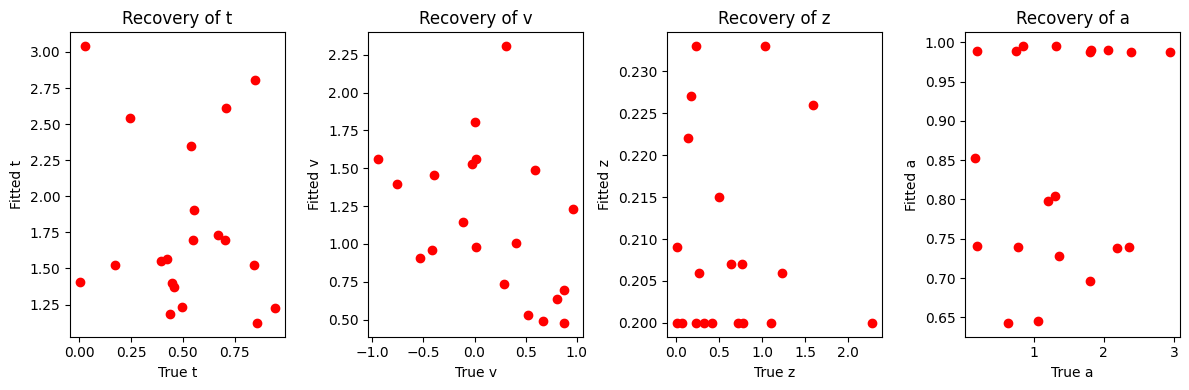

In [31]:
random.seed(1)

# non-decision time
min_T = 0.0
max_T = 1.0

# drift rate
min_v = -1.0
max_v = 1.0

# starting point
min_z = 0.0
max_z = 2.0

# boundary separation
min_a = 0.1
max_a = 3.0

num_samples = 20

# prepare the logging arrays:
true_ts = np.zeros(num_samples)
true_vs = np.zeros(num_samples)
true_zs = np.zeros(num_samples)
true_as = np.zeros(num_samples)

recovered_ts = np.zeros(num_samples)
recovered_vs = np.zeros(num_samples)
recovered_zs = np.zeros(num_samples)
recovered_as = np.zeros(num_samples)

# increment step
min_in = 0.001
max_in = 0.2
true_increment = random.uniform(min_in, max_in)

for index in range(num_samples):

    # randomly sample some parameters
    true_t = random.uniform(min_T, max_T)
    true_v = random.uniform(min_v, max_v)
    true_a = random.uniform(min_a, max_a)
    true_z = random.uniform(min_z, true_a) # z should never exceed a

    # log all true values
    for value, log in [(true_t, true_ts), (true_v, true_vs), (true_z, true_zs), (true_a, true_as)]:
      log[index] = value
      print(str(value))

    # simulate
    surrogate_model = Spotlight_DDM(name = "basic_simulation_model")

    # Simulate data with incremental changes in starting point
    surrogate_data = simulate_increment_model(500, surrogate_model, true_t, true_v, true_a, true_increment)

    hssm_dataset = hssm.simulate_data(
        model="ddm",
        theta=true_values,
        size=500,
    )

    # Perform MCMC sampling to infer the model parameters using the simulated data
    simulation_model = hssm.HSSM(
        data=hssm_dataset,
        model="ddm",
    )

    simulation_model_inference = simulation_model.sample(
        sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
        chains=2,               # the number of independent "runs" we sample through the room of parameters
        draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
        tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
    )

    # Summarize the MCMC traces
    summary = az.summary(simulation_model.traces)

    # log the recovered params
    for idx, log in enumerate([recovered_vs, recovered_zs, recovered_ts, recovered_as]):
        log[index] = summary["mean"][idx]

# Plot parameter recovery plots
parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as)

This function **simulate_increment_model** simulates multiple runs of a **DDM** with incremental changes in starting point


The next snippet, again, initializes random seed and iterates over a specified number of samples, randomly sampling true parameters within defined ranges.
For each sample, it logs the true parameter values and simulates data using a surrogate model with incremental changes in starting point.
The script performs MCMC sampling on the simulated data to recover parameters.
Recovered parameter values are logged and used to generate parameter recovery plots.

Compiling...


0.9560342718892494
0.8956549741186988
0.022406118998918468
0.26399896640774523
0.16726427674776048


Compilation time = 0:00:02.221878
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:02:36.074610
Transforming variables...
Transformation time = 0:00:00.067722
Computing Log Likelihood...
Log Likelihood time = 0:00:00.748503
Compiling...


0.7359699890685233
0.3394608028804418
0.6020635338238619
0.9935957270085182
0.12175354499452674


Compilation time = 0:00:01.389663
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:06:17.580552
Transforming variables...
Transformation time = 0:00:00.062406
Computing Log Likelihood...
Log Likelihood time = 0:00:00.676071
Compiling...


0.5812040171120031
-0.6832342594903889
0.5308515836284822
1.3489419568446792
0.14487940416625572


Compilation time = 0:00:03.286276
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:25.620822
Transforming variables...
Transformation time = 0:00:00.087211
Computing Log Likelihood...
Log Likelihood time = 0:00:00.796703
Compiling...


0.9948195629497427
0.8987909461864871
0.7465157918490478
1.6781134375450304
0.05437990758821629


Compilation time = 0:00:01.510232
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:06:15.782813
Transforming variables...
Transformation time = 0:00:00.065426
Computing Log Likelihood...
Log Likelihood time = 0:00:00.676635
Compiling...


0.03592432939285761
-0.945110285818362
0.4611987141558779
1.4481922000822052
0.07662296945824162


Compilation time = 0:00:01.679723
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.810063
Transforming variables...
Transformation time = 0:00:00.062331
Computing Log Likelihood...
Log Likelihood time = 0:00:00.711932
Compiling...


0.8917894578282874
0.05150553829205662
0.40742622760123043
1.7254800469768468
0.005747757749015657


Compilation time = 0:00:01.885082
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:08.597290
Transforming variables...
Transformation time = 0:00:00.062881
Computing Log Likelihood...
Log Likelihood time = 0:00:00.700038
Compiling...


0.32514292876116
-0.7266052140270667
1.5775696525383607
1.5796491529278833
0.13522145977182815


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Vector(float32, shape=(500,)) (of Variable Alloc.0) into Type Vector(bool, shape=(500,)). You can try to manually convert Alloc.0 into a Vector(bool, shape=(500,)). local_inline_composite_constants
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_inline_composite_constants
ERROR (pytensor.graph.rewriting.basic): node: Composite{...}([0.3351429 ... .33514294], ExpandDims{axis=0}.0, [0.5], Composite{sqr((-i0))}.0, ExpandDims{axis=0}.0, [3.1415927e-15], [1.e-15], [6.2831855], [0.31830987], [1])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/max/miniconda3/envs/flanker/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1968, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/home/max/miniconda3/envs/flanker/lib/python3.11/site-packages/pytensor/

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:02:47.610529
Transforming variables...
Transformation time = 0:00:00.064821
Computing Log Likelihood...
Log Likelihood time = 0:00:00.791087
Compiling...


0.18184349682314438
0.787143073165977
1.770351488732956
2.4106037721227547
0.18141213632961464


Compilation time = 0:00:02.351216
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:17.159109
Transforming variables...
Transformation time = 0:00:00.062327
Computing Log Likelihood...
Log Likelihood time = 0:00:00.734813
Compiling...


0.762885483833071
0.5794952749235265
1.1045621949569544
1.1259822357406502
0.19241828664174693


<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> Cannot convert Type Vector(float32, shape=(500,)) (of Variable Alloc.0) into Type Vector(bool, shape=(500,)). You can try to manually convert Alloc.0 into a Vector(bool, shape=(500,)). local_inline_composite_constants
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_inline_composite_constants
ERROR (pytensor.graph.rewriting.basic): node: Composite{...}([0.7728855 ... 0.7728855], ExpandDims{axis=0}.0, [0.5], Composite{sqr((-i0))}.0, ExpandDims{axis=0}.0, [3.1415927e-15], [1.e-15], [6.2831855], [0.31830987], [1])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/home/max/miniconda3/envs/flanker/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1968, in process_node
    fgraph.replace_all_validate_remove(  # type: ignore
  File "/home/max/miniconda3/envs/flanker/lib/python3.11/site-packages/pytensor/

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:02:46.868571
Transforming variables...
Transformation time = 0:00:00.065825
Computing Log Likelihood...
Log Likelihood time = 0:00:00.739480
Compiling...


0.16118465330401888
0.5080081433037442
1.00306937136876
2.173937604888615
0.10654078750856556


Compilation time = 0:00:01.325151
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:05:40.116193
Transforming variables...
Transformation time = 0:00:00.062549
Computing Log Likelihood...
Log Likelihood time = 0:00:00.647354
Compiling...


0.4900139218501913
0.8496641441891406
1.2908911152843399
1.552439081628899
0.07143091676887446


Compilation time = 0:00:02.292603
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:14.188033
Transforming variables...
Transformation time = 0:00:00.063295
Computing Log Likelihood...
Log Likelihood time = 0:00:00.784409
Compiling...


0.8828509185812531
0.7994011775132515
0.8157554432753107
1.4369352781567493
0.18414575739919384


Compilation time = 0:00:01.368649
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:05:54.259974
Transforming variables...
Transformation time = 0:00:00.061209
Computing Log Likelihood...
Log Likelihood time = 0:00:00.696475
Compiling...


0.7237729538720183
-0.026782890276829896
0.24130955614741806
0.7432519318739315
0.1402147559759785


Compilation time = 0:00:02.354804
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:04.453056
Transforming variables...
Transformation time = 0:00:00.064040
Computing Log Likelihood...
Log Likelihood time = 0:00:00.760514
Compiling...


0.16606968549412615
0.8158809932521891
0.7998240836296624
0.8775987874094674
0.06260306186494267


Compilation time = 0:00:01.348031
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:06:00.255680
Transforming variables...
Transformation time = 0:00:00.065689
Computing Log Likelihood...
Log Likelihood time = 0:00:00.706875
Compiling...


0.957361711556158
0.4124116127352093
0.8088884868625115
1.562321569251621
0.13063146539439138


Compilation time = 0:00:02.216220
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:05:57.052994
Transforming variables...
Transformation time = 0:00:00.064879
Computing Log Likelihood...
Log Likelihood time = 0:00:00.714673
Compiling...


0.5879447117944846
-0.3763113508979996
0.35969274218297365
0.7026735761599889
0.18689671746762196


Compilation time = 0:00:01.727381
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:25.850486
Transforming variables...
Transformation time = 0:00:00.066824
Computing Log Likelihood...
Log Likelihood time = 0:00:00.813657
Compiling...


0.6232650867258723
-0.8492492618519092
1.7997444244096765
2.479159984664849
0.18162307056931287


Compilation time = 0:00:02.316197
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:07:25.936027
Transforming variables...
Transformation time = 0:00:00.063473
Computing Log Likelihood...
Log Likelihood time = 0:00:00.703087
Compiling...


0.1914027333041175
0.4895654485547083
0.17654736641641852
0.27040079955610163
0.05534684673509272


Compilation time = 0:00:01.370729
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:06:07.128818
Transforming variables...
Transformation time = 0:00:00.061499
Computing Log Likelihood...
Log Likelihood time = 0:00:00.669445
Compiling...


0.22661652924476305
0.7509823428964757
0.2132134741378293
0.4081713496720222
0.17093465842978955


Compilation time = 0:00:02.432816
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:03:25.954026
Transforming variables...
Transformation time = 0:00:00.083447
Computing Log Likelihood...
Log Likelihood time = 0:00:00.815848
Compiling...


0.2448319779690169
-0.579042122608707
1.1222911088085097
2.6536871021622117
0.14367525868209008


Compilation time = 0:00:01.467721
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:07:30.125706
Transforming variables...
Transformation time = 0:00:00.098749
Computing Log Likelihood...
Log Likelihood time = 0:00:00.693039


Pearson correlation coefficient for t: -0.5635597167002111
Pearson correlation coefficient for v: 0.6366008130382469
Pearson correlation coefficient for z: -0.21592803693764462
Pearson correlation coefficient for a: -0.21662266184003176


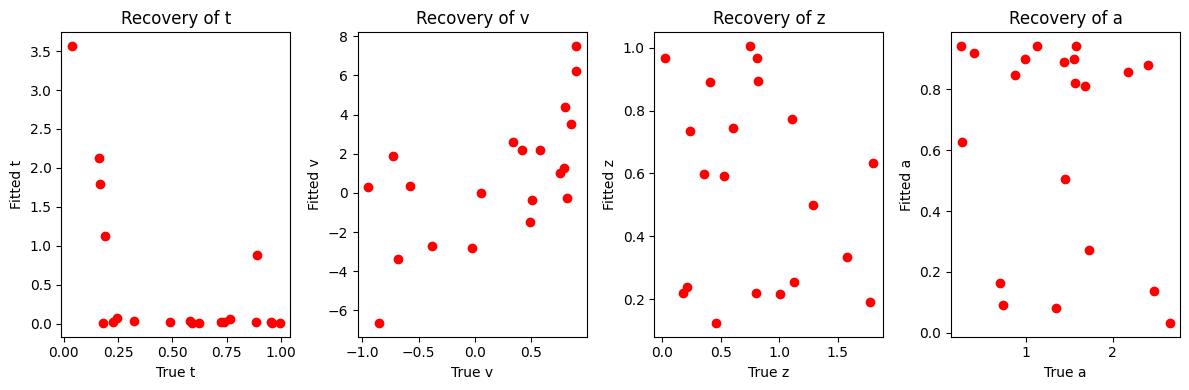

In [32]:
random.seed(2)

# non-decision time
min_T = 0.0
max_T = 1.0

# drift rate
min_v = -1.0
max_v = 1.0

# starting point
min_z = 0.0
max_z = 2.0

# boundary separation
min_a = 0.1
max_a = 3.0

# increment step
min_in = 0.001
max_in = 0.2

num_samples = 20

# prepare the logging arrays:
true_ts = np.zeros(num_samples)
true_vs = np.zeros(num_samples)
true_zs = np.zeros(num_samples)
true_as = np.zeros(num_samples)
true_ins = np.zeros(num_samples)

recovered_ts = np.zeros(num_samples)
recovered_vs = np.zeros(num_samples)
recovered_zs = np.zeros(num_samples)
recovered_as = np.zeros(num_samples)




# Iterate over the number of samples
for index in range(num_samples):

    # randomly sample some parameters
    true_t = random.uniform(min_T, max_T)
    true_v = random.uniform(min_v, max_v)
    true_a = random.uniform(min_a, max_a)
    true_z = random.uniform(min_z, true_a) # z should never exceed a
    true_increment = random.uniform(min_in, max_in)

    # log all true values
    for value, log in [(true_t, true_ts), (true_v, true_vs), (true_z, true_zs), (true_a, true_as), (true_increment, true_ins)]:
      log[index] = value
      print(str(value))

    # Create a surrogate model
    surrogate_model = Spotlight_DDM_with_variable_z(name = "simulation_model", starting_point = true_z)

    # Simulate data with incremental changes in starting point
    surrogate_data = simulate_increment_model(500, surrogate_model, true_t, true_v, true_a, true_increment)

    # Define the simulation model
    simulation_model = hssm.HSSM(
        data=surrogate_data,
        model="ddm",
    )

    # Perform MCMC sampling
    simulation_model_inference = simulation_model.sample(
        sampler="nuts_numpyro", # the specific MCMC sampling strategy we are using
        chains=2,               # the number of independent "runs" we sample through the room of parameters
        draws=1000,             # the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
        tune=1000,              # the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
        idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
    )

    # Summarize the posterior distribution
    summary = az.summary(simulation_model.traces)

    # log the recovered params
    for idx, log in enumerate([recovered_vs, recovered_zs, recovered_ts, recovered_as]):
        log[index] = summary["mean"][idx]

# Generate parameter recovery plots
parameter_recovery_plots(true_ts, recovered_ts, true_vs, recovered_vs, true_zs, recovered_zs, true_as, recovered_as)

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [33]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





The code loads experimental data from a CSV file.
It fits the two DDMs, performs MCMC sampling (using the NUTS sampler) to infer parameters for both models and compares them based on the traces obtained from MCMC sampling.
Finally, trace plots are generated for visualizing parameter estimates and convergence for both models, as well as a summary of the infered parameters.

In [34]:
# Loading the experimental data
data = pd.read_csv("../data/3029.csv", delimiter=";")

# Fit Standard model
basic_ddm_model = hssm.HSSM(
    data = data,
)

# Perform MCMC sampling to infer parameters for the standard DDM
basic_ddm_model_inference = basic_ddm_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)



# Fit Model with varying z-value
varying_starting_point_model = hssm.HSSM(
    data = data,
    include=[
        {
            "name": "z",
            "formula": "z ~ 1 + previous_response",
        }
    ],
)

# Perform MCMC sampling to infer parameters for DDM with varying starting point
varying_starting_point_model_inference = varying_starting_point_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    chains=4,               # this is the number of independent "runs" we sample through the room of parameters
    draws=1000,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=1000,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

# Compare the two models based on their traces
model_comparison = az.compare(
    {
        "varying starting point": varying_starting_point_model.traces,
        "basic": basic_ddm_model.traces,
    }
)

print(model_comparison)

Compiling...
Compilation time = 0:00:02.142751
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:04.373908
Transforming variables...
Transformation time = 0:00:00.065050
Computing Log Likelihood...
Log Likelihood time = 0:00:00.605765
Compiling...
Compilation time = 0:00:02.069781
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:12.977024
Transforming variables...
Transformation time = 0:00:00.060983
Computing Log Likelihood...
Log Likelihood time = 0:00:00.585593


                        rank     elpd_loo       p_loo  elpd_diff  \
varying starting point     0 -1344.860975  924.065248   0.000000   
basic                      1 -1378.408306    0.029505  33.547331   

                              weight        se       dse  warning scale  
varying starting point  1.000000e+00  0.012371  0.000000    False   log  
basic                   1.733724e-12  0.015019  0.002648    False   log  


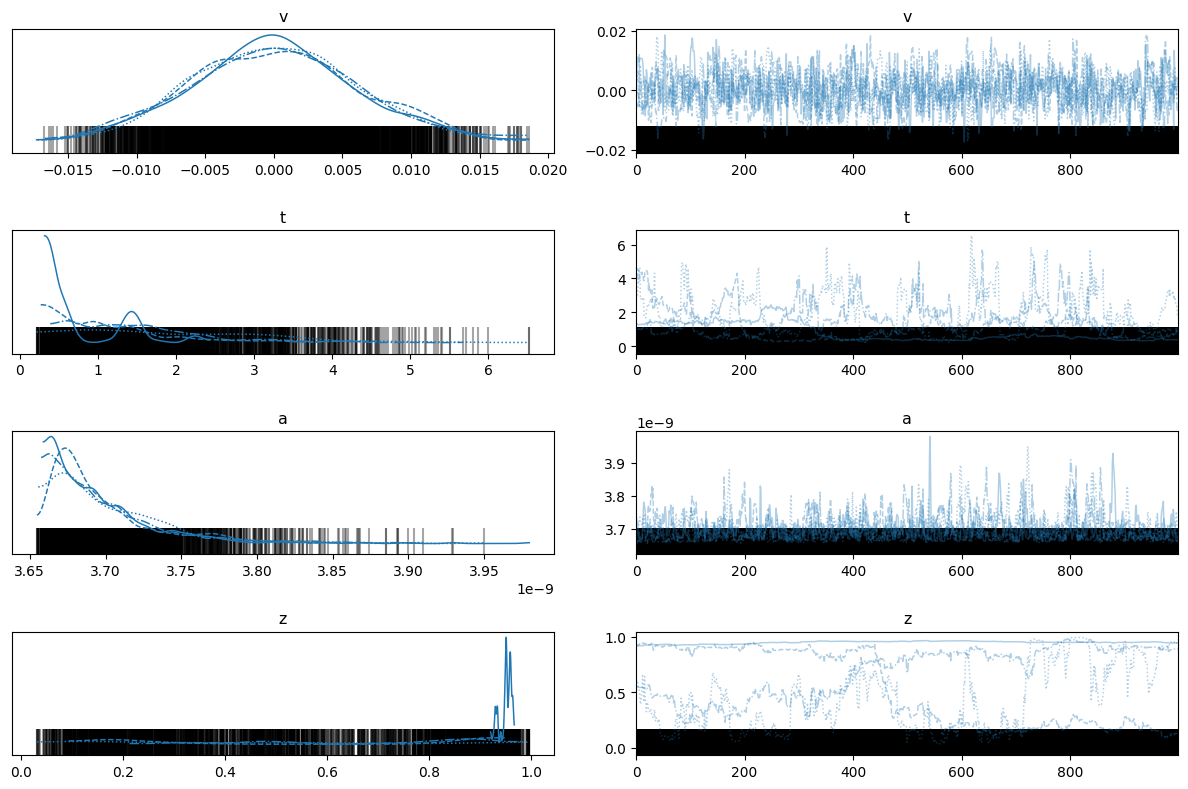

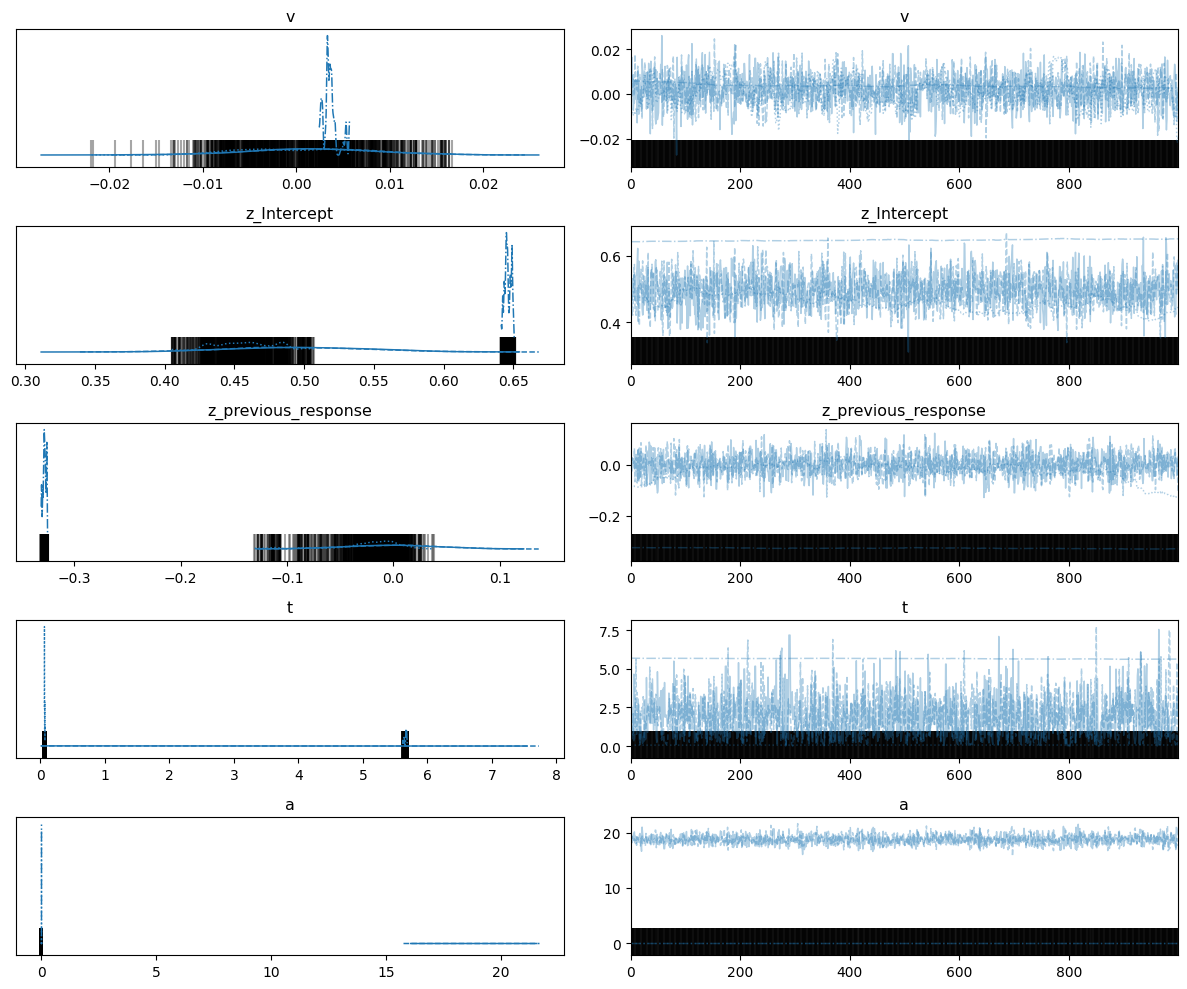

In [35]:
# Plot traces for the standard DDM and DDM with varying starting point
basic_ddm_model.plot_trace()
varying_starting_point_model.plot_trace()

The first trace plot refers to the basic model with a fixed z-value. While the curves show better recovery for the parameters in the basic, we assume that even better fitting might be possible when using more than our 48 datapoints.

In [36]:
az.summary(basic_ddm_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.000,0.006,-0.011,0.011,0.000,0.000,716.0,1135.0,1.00
t,1.386,1.023,0.265,3.356,0.233,0.167,18.0,88.0,1.18
a,0.000,0.000,0.000,0.000,0.000,0.000,444.0,729.0,1.01
z,0.651,0.318,0.125,0.976,0.137,0.106,7.0,57.0,1.67


In [37]:
az.summary(varying_starting_point_model.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,0.002,0.006,-0.011,0.013,0.000,0.000,464.0,742.0,1.29
z_Intercept,0.524,0.082,0.424,0.651,0.036,0.028,6.0,12.0,1.69
z_previous_response,-0.089,0.143,-0.331,0.052,0.069,0.054,6.0,12.0,1.65
t,2.383,2.254,0.062,5.679,1.022,0.788,5.0,19.0,2.32
a,9.377,9.398,0.000,19.774,4.671,3.576,6.0,43.0,2.10
